# Cyber Bullying Classifier 

## Data Import 

In [1]:
import pandas as pd 
raw_data = pd.read_csv("train.csv")
raw_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Preparing the Data for cleaning 

In [2]:
print(raw_data.columns.tolist())

['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 
raw_data["bully"] = (raw_data[label_cols].max(axis=1) > 0).astype(int)
raw_data = raw_data[["comment_text", "bully"]]
raw_data

,comment_text,bully
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


## Data Cleaning 


In [4]:
raw_data = raw_data.copy()
raw_data["clean_text"] = (
    raw_data["comment_text"]
    .str.lower()
    .str.replace("http", " URL ", regex=False)   
    .str.replace("www", " URL ", regex=False)
    .str.replace("@", " USER ", regex=False)    
    .str.replace(r"[^a-z\s\U0001F600-\U0001F64F]", "", regex=True)  
    .str.replace(r"\s+", " ", regex=True)   
    .str.replace(r"\d+", " NUM ", regex=True)
    .str.strip()                                
)

cleaned_data = raw_data[['clean_text', 'bully']].copy()
cleaned_data

,clean_text,bully
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159566,and for the second time of asking when your vi...,0
159567,you should be ashamed of yourself that is a ho...,0
159568,spitzer umm theres no actual article for prost...,0
159569,and it looks like it was actually you who put ...,0


## Division into label and target 

In [5]:
x =  cleaned_data['clean_text']
y = cleaned_data['bully']

## Splitting Into Training and Testing data

In [6]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42, stratify = y)

## Vectorization On Text Strings

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf  = vectorizer.transform(x_test)

## Train Logistic Regression 


In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(x_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Predict & Evaluate 

In [9]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

y_pred = model.predict(x_test_tfidf)

print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.6962962962962963
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     28670
           1       0.59      0.85      0.70      3245

    accuracy                           0.92     31915
   macro avg       0.79      0.89      0.83     31915
weighted avg       0.94      0.92      0.93     31915

[[26723  1947]
 [  472  2773]]


In [10]:
import numpy as np
from sklearn.metrics import f1_score

probs = model.predict_proba(x_test_tfidf)[:, 1]
thresholds = np.linspace(0.05, 0.95, 19)

best_t, best_f1 = 0.5, -1
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_t, best_f1 = t, f1

print(f"Best threshold: {best_t:.2f}, F1: {best_f1:.4f}")

Best threshold: 0.75, F1: 0.7583


## Train SVM (Support Vector Machine) 

In [11]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)
svm_model.fit(x_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


### Predict & Evaluate

In [12]:
y_pred_svm = svm_model.predict(x_test_tfidf)


In [13]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("F1 Score:", f1_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


F1 Score: 0.7611940298507462
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28670
           1       0.87      0.68      0.76      3245

    accuracy                           0.96     31915
   macro avg       0.92      0.83      0.87     31915
weighted avg       0.95      0.96      0.95     31915

[[28346   324]
 [ 1052  2193]]


## Comparison of Logistic Regression & SVM 

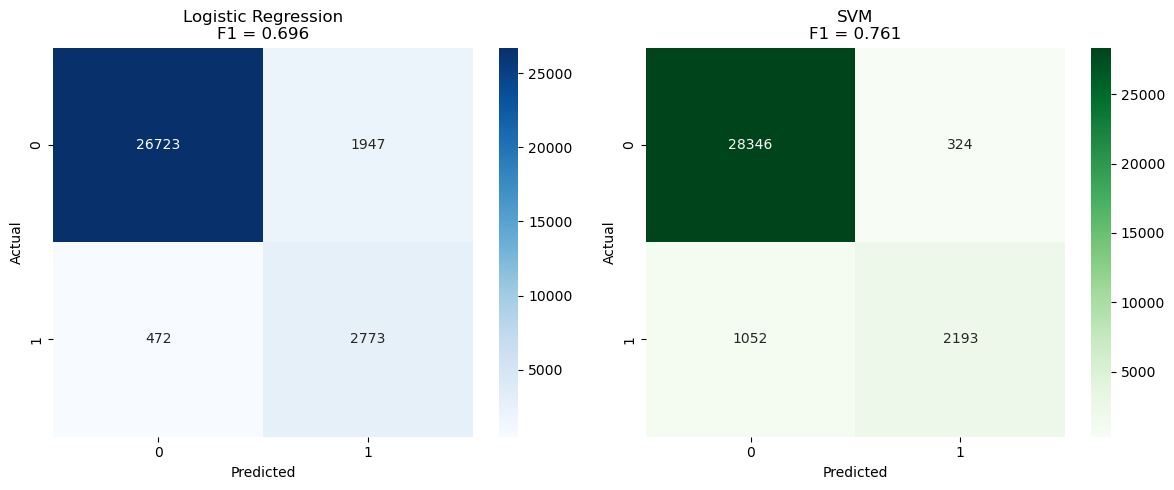

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Logistic Regression predictions
y_pred_lr = model.predict(x_test_tfidf)   
cm_lr = confusion_matrix(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# SVM predictions
y_pred_svm = svm_model.predict(x_test_tfidf)  
cm_svm = confusion_matrix(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Ploting confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title(f"Logistic Regression\nF1 = {f1_lr:.3f}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title(f"SVM\nF1 = {f1_svm:.3f}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


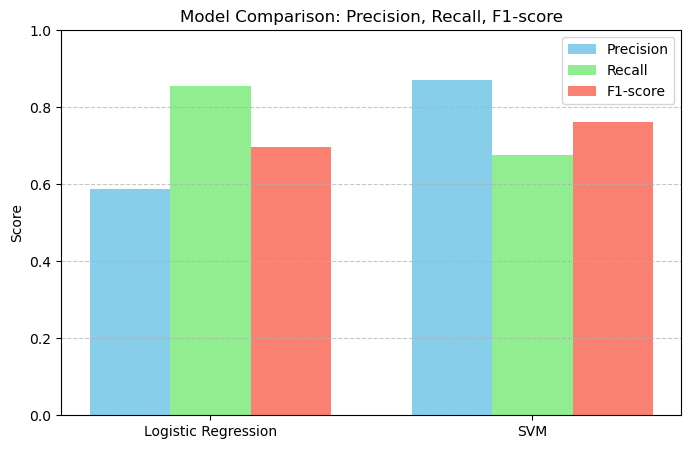

In [ ]:

import numpy as np


models = ['Logistic Regression', 'SVM']

# Metrics for each model
precision = [0.588, 0.871]  # LR and SVM
recall = [0.854, 0.676]
f1 = [0.696, 0.761]

# X-axis positions
x = np.arange(len(models))
width = 0.25  # width of the bars

# bar chart
plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-score', color='salmon')


plt.ylabel('Score')
plt.title('Model Comparison: Precision, Recall, F1-score')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()


## Saving Results into CSV 

In [20]:

df_results = pd.DataFrame({
    'Text':  x_test,    
    'Actual': y_test,         
    'Predicted': y_pred      
})

# Save to CSV 
df_results.to_csv('logistic_predictions.csv', index=False)
